In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import pandas as pd

style.use('default')
import matplotlib.path as mpath

In [49]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['diatC', 'coccoC','spC','diazC','zoo1C','zoo2C','zoo3C','zoo4C',
             'IFRAC','PD','Fe','diatChl','spChl','diazChl','coccoChl','HMXL','XMXL']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

#### get case

In [50]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.004
diatC
coccoC
spC
diazC
zoo1C
zoo2C
zoo3C
zoo4C
IFRAC
PD
Fe
diatChl
spChl
diazChl
coccoChl
HMXL
XMXL
CPU times: user 10.6 s, sys: 2.31 s, total: 12.9 s
Wall time: 15.9 s


In [51]:
### snip off the first two years, as these are still adjusting from initialization
ds = ds.isel(time=slice(2,61))

ds['totChl'] = ds.spChl + ds.diatChl + ds.diazChl + ds.coccoChl

In [52]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.where(tmp>0).sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diazC * 10.
ds['diazC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint'] + ds['diazC_zint']

In [53]:
ds['diat_frac'] = ds.diatC_zint/(ds.diatC_zint + ds.spC_zint)

In [54]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1.e-4
depths=ds_grid.z_t * 0.01
tlen=len(ds.time)
years = np.arange(1960,1960+tlen,1)
years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

### Get SAM indices

In [55]:
csv_file = '/glade/work/kristenk/SAM_index/SAM_indices.csv'
sam_indices = pd.read_csv(csv_file, header=None)
sam_indices.columns = ['year', 'ANN', 'AUT' , 'WIN', 'SPR', 'SUM']
sam_indices

year   ANN   AUT   WIN   SPR   SUM
0   1957 -4.24 -2.52 -0.68 -3.55 -2.52
1   1958 -1.27 -2.97 -0.92  1.42  1.12
2   1959  0.47 -0.94 -1.22  3.20  0.31
3   1960  1.52  0.74  0.32  1.00 -0.08
4   1961  1.22  0.48  0.93  0.85  2.19
..   ...   ...   ...   ...   ...   ...
58  2015  4.13  1.43  3.19  1.75  2.19
59  2016  1.67  1.64  1.49 -0.31 -1.75
60  2017  1.67  1.34  1.15  1.42  2.33
61  2018  1.96 -0.81 -0.76  3.92  1.43
62  2019 -1.50  1.03 -1.30 -2.57 -0.96

[63 rows x 6 columns]

### plotting function (helps with South Pole stereographic map)

In [56]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### do mean, st dev, and mean/stdev calculations

In [57]:
st_dev_zoo4 = ds.zoo4C_zint.std(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo4 = ds.zoo4C_zint.mean(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo4 = st_dev_zoo4/mean_zoo4

st_dev_zoo3 = ds.zoo3C_zint.std(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo3 = ds.zoo3C_zint.mean(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo3 = st_dev_zoo3/mean_zoo3

tmp = ds.zoo1C_zint + ds.zoo2C_zint
st_dev_zoo1_2 = tmp.std(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
mean_zoo1_2 = tmp.mean(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_zoo1_2 = st_dev_zoo1_2/mean_zoo1_2

st_dev_diat = ds.diatC_zint.std(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
mean_diat = ds.diatC_zint.mean(dim='time').where(ds.PD.isel(z_t=0,time=0)>0.)
norm_stdev_diat = st_dev_diat/mean_diat

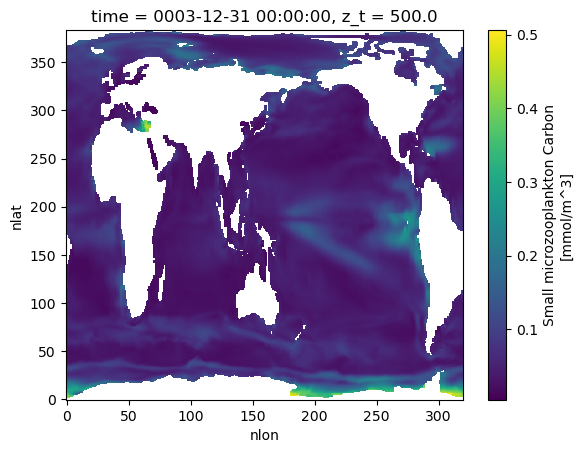

In [58]:
norm_stdev_zoo1_2.plot()

### Do SAM annual correlations

In [59]:
ann_sam = sam_indices.ANN.values
time_sam = sam_indices.year.values

na = np.newaxis
da_sam = ann_sam[:,na,na]
da_sam = xr.DataArray(da_sam, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam = da_sam.isel(time=slice(3,62))

In [60]:
zoo4_sam_ann_corr = xr.corr(ds.zoo4C_zint, da_sam, dim='time')
zoo4_sam_ann_corr = zoo4_sam_ann_corr.squeeze()

zoo3_sam_ann_corr = xr.corr(ds.zoo3C_zint, da_sam, dim='time')
zoo3_sam_ann_corr = zoo3_sam_ann_corr.squeeze()

zoo1_2_sam_ann_corr = xr.corr(ds.zoo1C_zint+ ds.zoo1C_zint, da_sam, dim='time')
zoo1_2_sam_ann_corr = zoo1_2_sam_ann_corr.squeeze()

diat_sam_ann_corr = xr.corr(ds.diatC_zint, da_sam, dim='time')
diat_sam_ann_corr = diat_sam_ann_corr.squeeze()

### Do SAM summer correlations

In [61]:
sum_sam = sam_indices.SUM.values
time_sam = sam_indices.year.values

na = np.newaxis
da_sam_sum = sum_sam[:,na,na]
da_sam_sum = xr.DataArray(da_sam_sum, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam_sum = da_sam_sum.isel(time=slice(3,62))

In [62]:
zoo4_sam_sum_corr = xr.corr(ds.zoo4C_zint, da_sam_sum, dim='time')
zoo4_sam_sum_corr = zoo4_sam_sum_corr.squeeze()

zoo3_sam_sum_corr = xr.corr(ds.zoo3C_zint, da_sam_sum, dim='time')
zoo3_sam_sum_corr = zoo3_sam_sum_corr.squeeze()

zoo1_2_sam_sum_corr = xr.corr(ds.zoo1C_zint+ ds.zoo1C_zint, da_sam_sum, dim='time')
zoo1_2_sam_sum_corr = zoo1_2_sam_sum_corr.squeeze()

diat_sam_sum_corr = xr.corr(ds.diatC_zint, da_sam_sum, dim='time')
diat_sam_sum_corr = diat_sam_sum_corr.squeeze()

### Do SAM winter correlations

In [63]:
win_sam = sam_indices.WIN.values
time_sam = sam_indices.year.values

na = np.newaxis
da_sam_win = win_sam[:,na,na]
da_sam_win = xr.DataArray(da_sam_win, dims=('time','lat','lon'))

#just get the overlapping timeperiod with the model
da_sam_win = da_sam_win.isel(time=slice(3,62))

In [64]:
zoo4_sam_win_corr = xr.corr(ds.zoo4C_zint, da_sam_win, dim='time')
zoo4_sam_win_corr = zoo4_sam_win_corr.squeeze()

zoo3_sam_win_corr = xr.corr(ds.zoo3C_zint, da_sam_win, dim='time')
zoo3_sam_win_corr = zoo3_sam_win_corr.squeeze()

zoo1_2_sam_win_corr = xr.corr(ds.zoo1C_zint+ ds.zoo1C_zint, da_sam_win, dim='time')
zoo1_2_sam_win_corr = zoo1_2_sam_win_corr.squeeze()

diat_sam_win_corr = xr.corr(ds.diatC_zint, da_sam_win, dim='time')
diat_sam_win_corr = diat_sam_win_corr.squeeze()

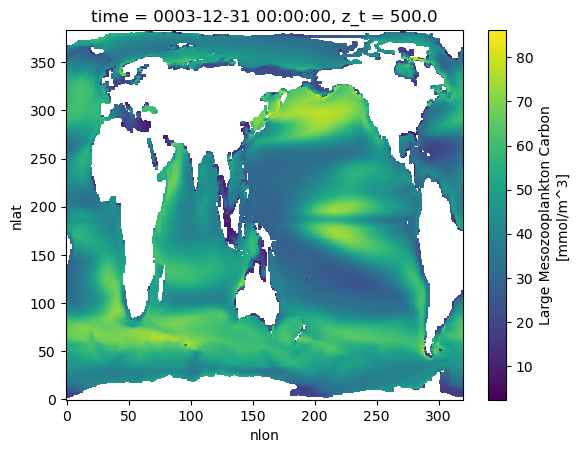

In [65]:
mean_zoo4.plot()

### zoo4 plots

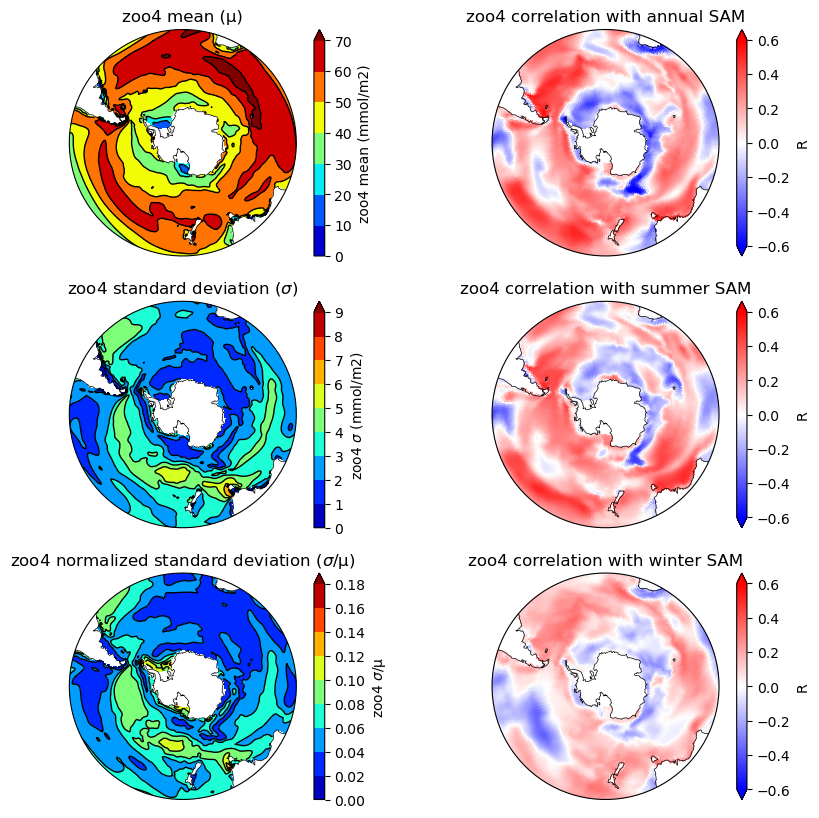

In [66]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo4)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,80,10)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo4 mean (mmol/m2)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo4)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,10,1)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo4 ${\sigma}$ (mmol/m2)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo4)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.2,0.02)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo4 ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

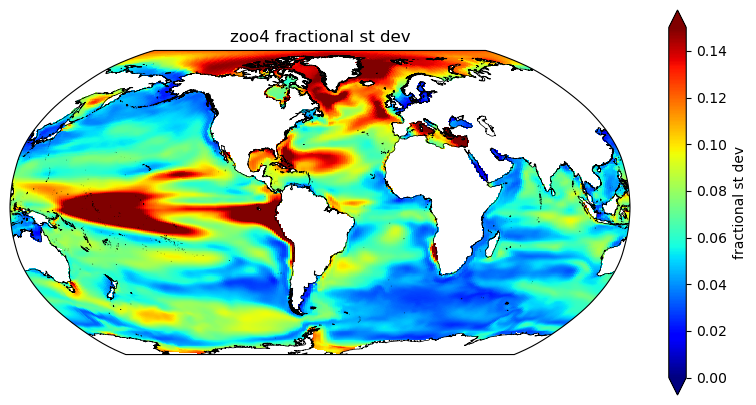

In [67]:
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo4)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 fractional st dev', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.15,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='fractional st dev')

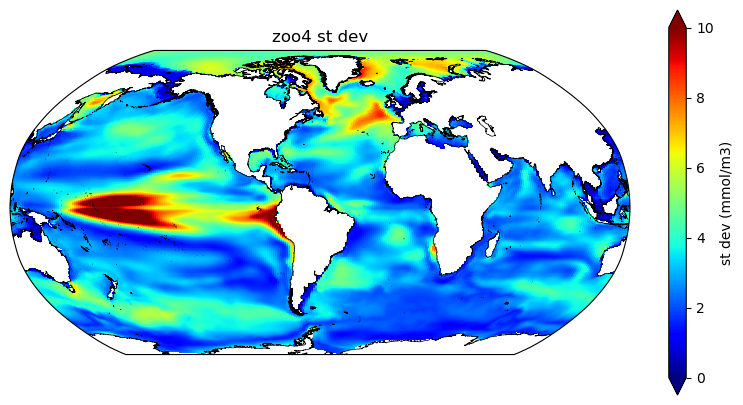

In [68]:
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo4)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 st dev', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='st dev (mmol/m3)')

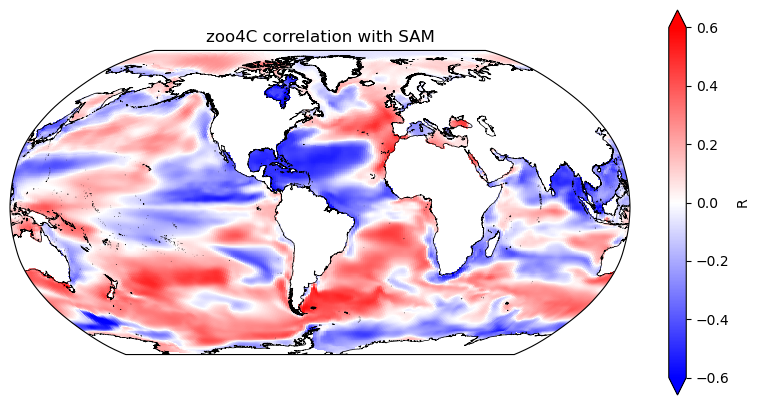

In [69]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_sam_ann_corr)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4C correlation with SAM', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.6,vmax=0.6,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### zoo3 plots

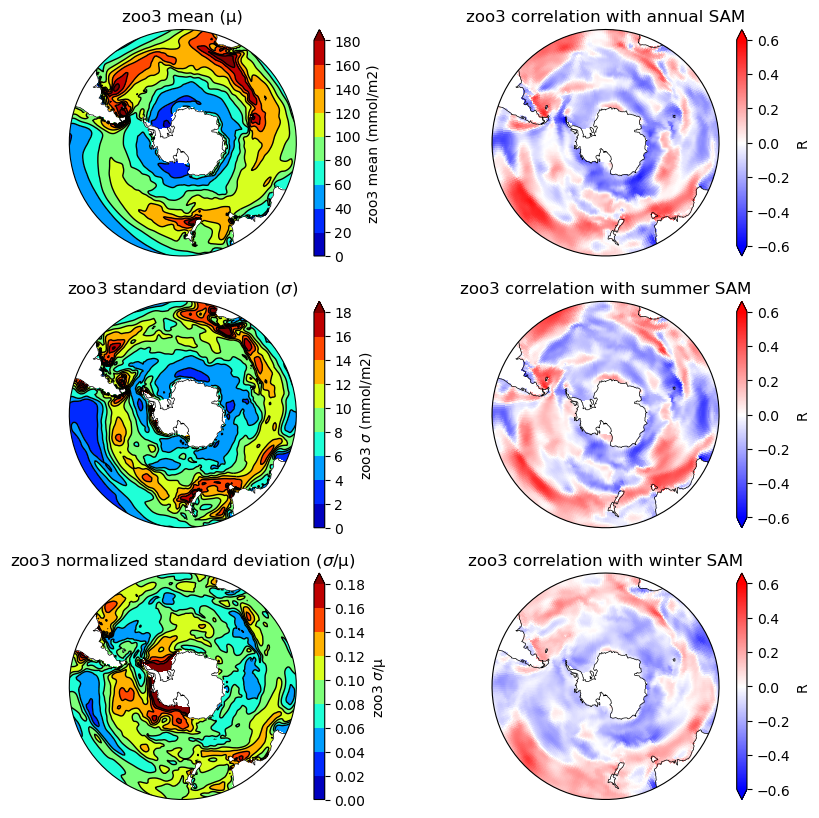

In [70]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,200,20)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 mean (mmol/m2)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,20,2)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 ${\sigma}$ (mmol/m2)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.2,0.02)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo3 ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo3 correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### Microzooplankton (zoo1 + zoo2)

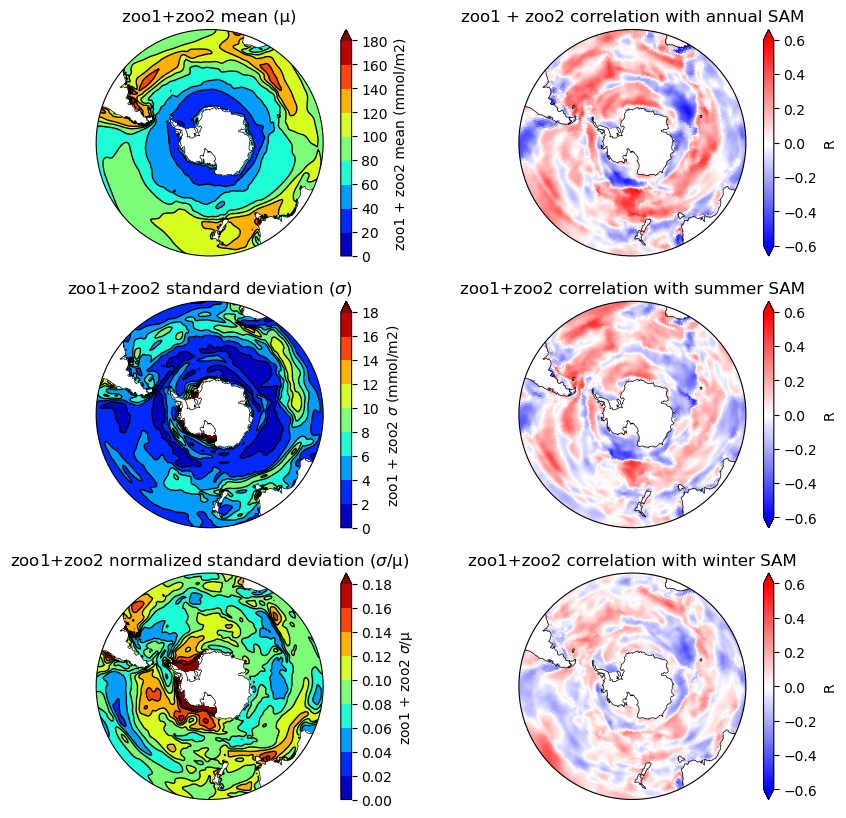

In [71]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_zoo1_2)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,200,20)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 + zoo2 mean (mmol/m2)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_zoo1_2)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,20,2)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 + zoo2 ${\sigma}$ (mmol/m2)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_zoo3)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.2,0.02)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='zoo1 + zoo2 ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_2_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1 + zoo2 correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_2_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_2_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo1+zoo2 correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### diatom plots

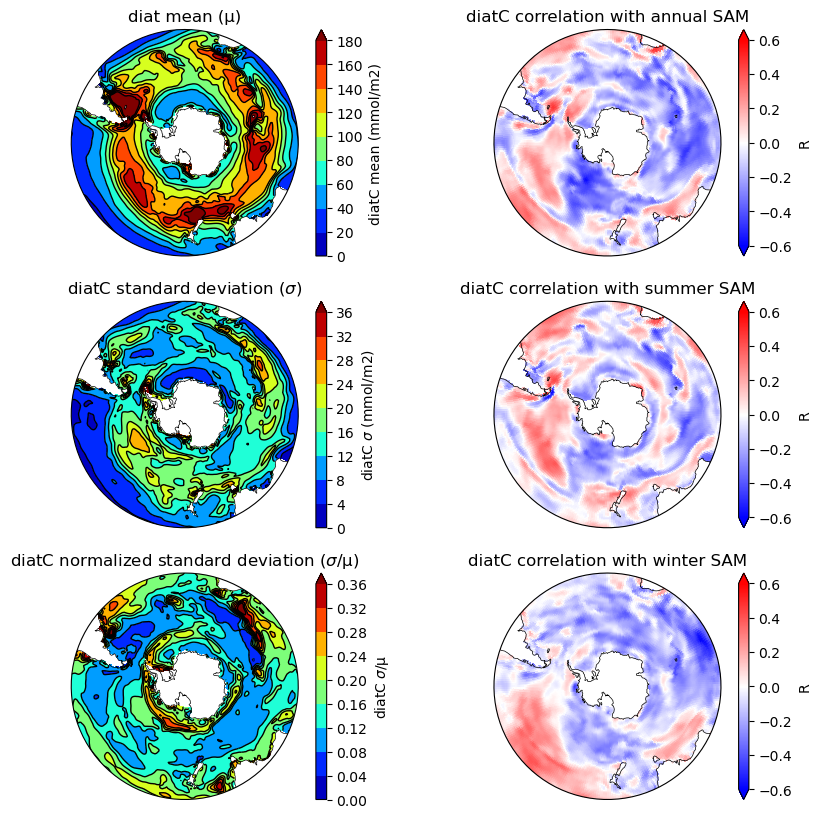

In [72]:
fig = plt.figure(figsize=(10,10))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, mean_diat)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,200,20)}

ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('diat mean (µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC mean (mmol/m2)')

#----------PLOT ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, st_dev_diat)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,40,4)}

ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC standard deviation (${\sigma}$)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC ${\sigma}$ (mmol/m2)')

#----------PLOT MEAN/ST DEV ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, norm_stdev_diat)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
contour_specs1 = {'levels': np.arange(0,0.4,0.04)}

ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC normalized standard deviation (${\sigma}$/µ)')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

cf = ax.contourf(lon,lat,field,
                     transform=ccrs.PlateCarree(),cmap='jet',extend='max',**contour_specs1)
cs = ax.contour(lon,lat,field, colors='black',
                levels = contour_specs1['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(cf, ax=ax,extend='max',label='diatC ${\sigma}$/µ')

#----------PLOT SAM annual correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM summer correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sam_sum_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC correlation with summer SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

#----------PLOT SAM winter correlation ---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, diat_sam_win_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('diatC correlation with winter SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### A few other correlations

In [33]:
zoo4_ifrac_corr = xr.corr(ds.zoo4C_zint, ds.IFRAC, dim='time')

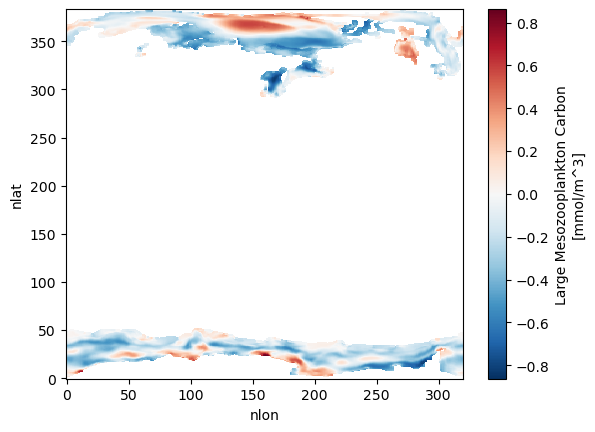

In [34]:
zoo4_ifrac_corr.plot()

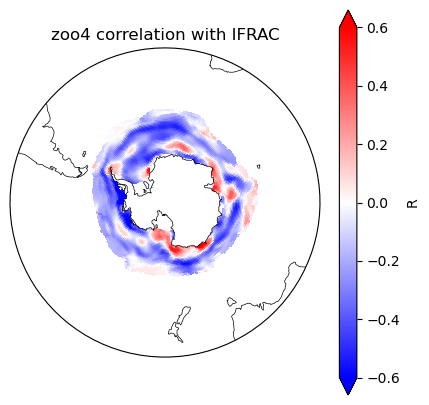

In [35]:
fig = plt.figure(figsize=(5,5))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_ifrac_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4 correlation with IFRAC')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')


In [36]:
ifrac_sam_ann_corr = xr.corr(ds.IFRAC, da_sam, dim='time')
ifrac_sam_ann_corr = ifrac_sam_ann_corr.squeeze()

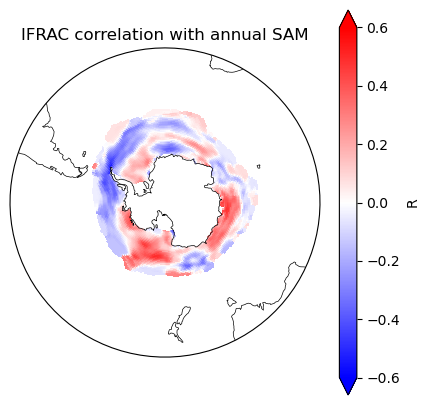

In [37]:
fig = plt.figure(figsize=(5,5))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, ifrac_sam_ann_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('IFRAC correlation with annual SAM')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')


### explore the effects of mixed layer depth

## zoo4C

In [73]:
zoo4_hmxl_corr = xr.corr(ds.zoo4C_zint, ds.HMXL, dim='time')
zoo4_xmxl_corr = xr.corr(ds.zoo4C_zint, ds.XMXL, dim='time')

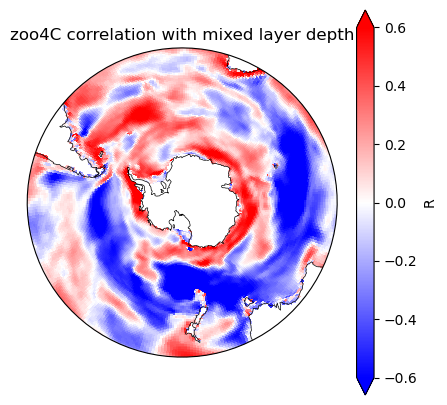

In [40]:
fig = plt.figure(figsize=(5,5))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_hmxl_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zoo4C correlation with mixed layer depth')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')


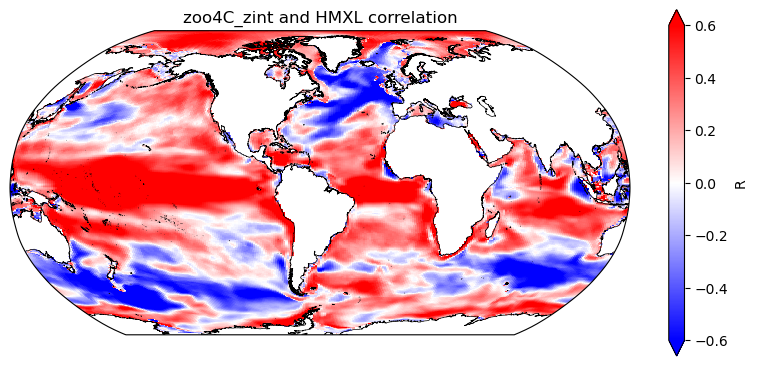

In [42]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_hmxl_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4C_zint and HMXL correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.6, vmax=0.6,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

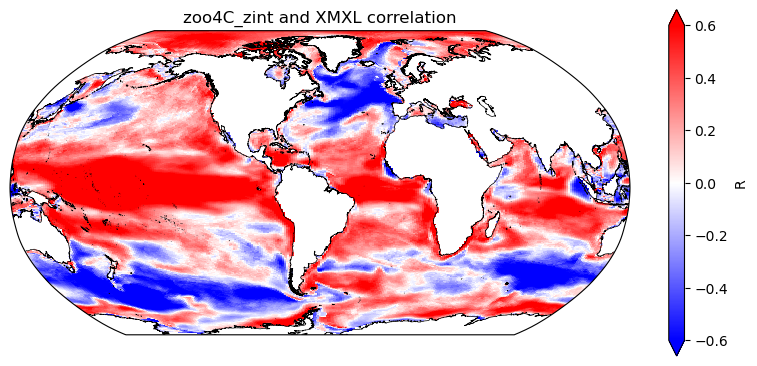

In [74]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_xmxl_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4C_zint and XMXL correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.6, vmax=0.6,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

## diatom fraction

In [43]:
zoo4_diatfrac_corr = xr.corr(ds.diat_frac, ds.HMXL, dim='time')

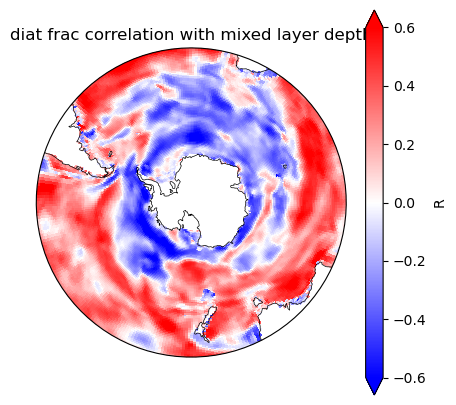

In [44]:
fig = plt.figure(figsize=(5,5))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_diatfrac_corr)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('diat frac correlation with mixed layer depth')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.6, vmax=0.6, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')


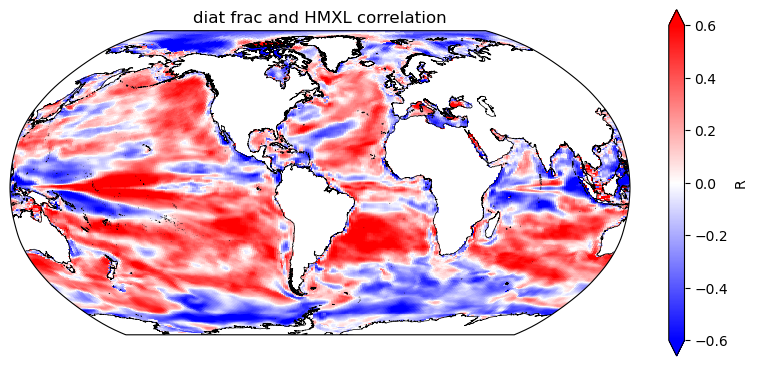

In [45]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_diatfrac_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diat frac and HMXL correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.6, vmax=0.6,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

### diat frac and zoo4C

In [75]:
zoo4C_diatfrac_corr = xr.corr(ds.diat_frac, ds.zoo4C_zint, dim='time')

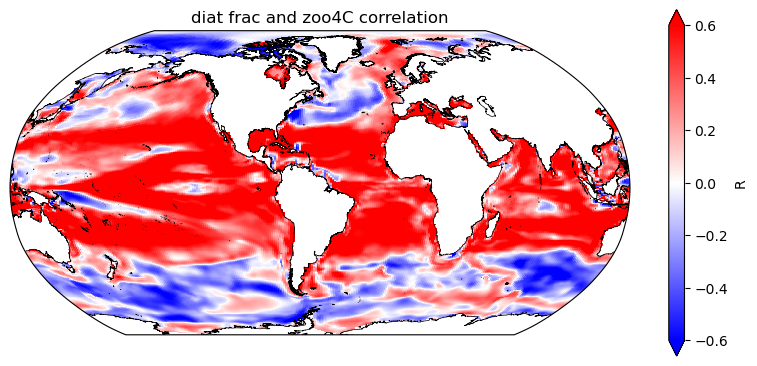

In [76]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo4C_diatfrac_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diat frac and zoo4C correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.6, vmax=0.6,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

## zoo4C + zoo3C

In [47]:
zoo3_4_HMXL_corr = xr.corr((ds.zoo3C_zint+ds.zoo4C_zint), ds.HMXL, dim='time')

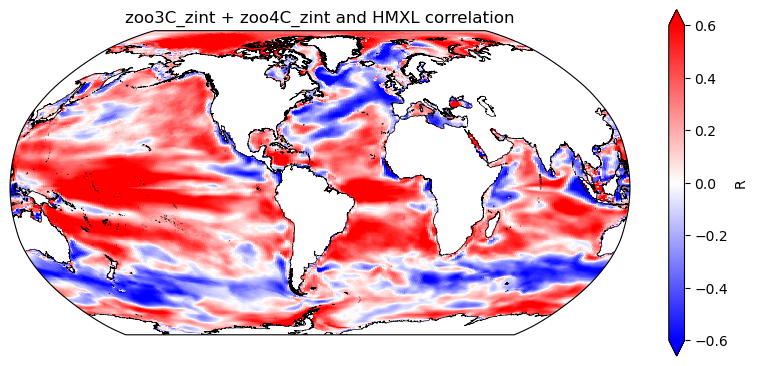

In [77]:
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_4_HMXL_corr)

fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo3C_zint + zoo4C_zint and HMXL correlation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-0.6, vmax=0.6,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')